<a href="https://colab.research.google.com/github/EdwynZN/TLGColab/blob/main/EdwinZambranoNemegyei_reto_C7SC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import v2
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

d:\Workspace\ML_learning_gate\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(100);

### Cargar y transformar dataset

Los archivos se encuentran en la carpeta de assets/Catsvsdogs/catsvsdogs

- Cambiar las dimensiones de las imagenes a un tamaño de 256x256 y normalizar de 0 a 1
- Crear dataset a partir de los subfolders de gatos y perros
- Crear set de entrenamiento, validación y prueba (80%-10%-10%)

In [ ]:
transform = v2.Compose([
    v2.Resize((196, 196)), ## imagen de 196x196
    # random augmentation
    #v2.RandomHorizontalFlip(0.35),
    #v2.RandomHorizontalFlip(0.35),
    #v2.RandomRotation([-30, 30]),
    #v2.ColorJitter(brightness=.25, hue=.25),
    #v2.ToTensor(),
    v2.ToImage(),
    #v2.ToPILImage(),
    v2.ToDtype(torch.float32, scale=True),
])

dataset = datasets.ImageFolder('assets/Catsvsdogs/catsvsdogs', transform=transform, target_transform= v2.ToDtype(torch.float32, scale=True))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

batch_size = 96
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

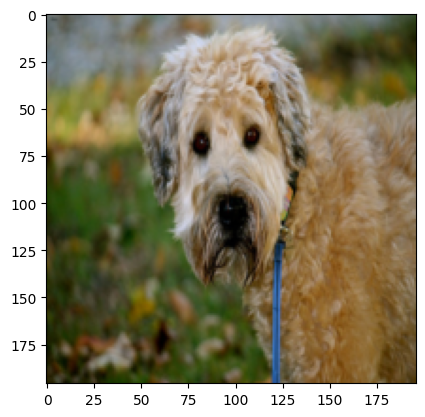

In [ ]:
pltransform = v2.ToPILImage()

plt.imshow(pltransform(train_dataset[0][0].data))

Modelo con:
- 3 capas de convolución y max pooling (y activación Relu)
- Aplanamiento de la salida del último max pooling
- 3 capas densas
- Dropout entre las capas densas
- Salida lineal

Se crea función de perdida (CrossEntropyLoss) y optimizador (Adam)

In [ ]:
model = nn.Sequential(
    ## CNN
    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=5, stride=1, padding=2, bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    ## Model
    nn.Flatten(),
    nn.Linear(in_features= 256*12*12, out_features=128, bias=True),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(in_features= 128, out_features=64, bias=True),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(in_features= 64, out_features=32, bias=True),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(in_features= 32, out_features=16, bias=True),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(in_features= 16, out_features=1, bias=True),
).to(device);

loss_fn = nn.BCEWithLogitsLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4) # optimizador Adam

### Entrenamiento

In [ ]:
def accuracy_fn(y_label, y_pred):
    correct = torch.eq(y_label, y_pred).sum().item()
    return correct / len(y_label)

n_epochs = 35
loss_per_batch = []
acc_per_batch = []
val_loss_per_batch = []
val_acc_per_batch = []

print('training...')
sm = nn.Sigmoid()
for epoch in range(n_epochs):
    model.train()
    acc = 0
    l = 0
    for x, label in tqdm(train_loader):
        x, label = x.to(device), label.to(device)
        output = model(x).squeeze()
        pred_probs = torch.round(sm(output))
        #loss = loss_fn(output, torch.unsqueeze(label.float(), dim=-1))
        loss = loss_fn(output, label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l += loss.cpu().item()
        acc += accuracy_fn(label, pred_probs)
        #acc += float((pred_probs == label).float().mean()) #float((pred_probs == label).sum().mean())
        #acc += float((output.round() == label).float().mean())
    acc_per_batch.append(round(acc / len(train_loader), 3))
    loss_per_batch.append(round(l / len(train_loader), 3))

    # evaluate accuracy at end of each epoch
    model.eval()
    acc = 0
    l = 0
    with torch.no_grad():
        for val_x, val_label in tqdm(val_loader):
            val_x, val_label = val_x.to(device), val_label.to(device)
            y_pred = model(val_x).squeeze()
            #loss = loss_fn(y_pred, torch.unsqueeze(val_label.float(), dim=-1))
            loss = loss_fn(y_pred, val_label.float())
            l += loss.cpu().item()
            pred_probs = torch.round(sm(y_pred))
            acc += accuracy_fn(val_label, pred_probs)
            #acc += float((pred_probs == val_label).float().mean()) #float((pred_probs.round() == val_label).sum().mean())
            #print(f'{pred_probs} {label}')
            #acc += float((y_pred.round() == val_label).float().mean())
    val_acc_per_batch.append(round(acc / len(val_loader), 3))
    val_loss_per_batch.append(round(l / len(val_loader), 3))

    #for name, param in model.named_parameters():
    #    print(name, param.grad)
    if (epoch % 5 == 0):
        print(f'Finished epoch {epoch + 1}: loss {loss_per_batch[-1]} - acc {acc_per_batch[-1]} - val_loss {val_loss_per_batch[-1]} - val_acc {val_acc_per_batch[-1]}')
print(f'Finished epoch {epoch + 1}: loss {loss_per_batch[-1]} - acc {acc_per_batch[-1]} - val_loss {val_loss_per_batch[-1]} - val_acc {val_acc_per_batch[-1]}')


training...


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Finished epoch 1: loss 0.741 - acc 0.498 - val_loss 0.709 - val_acc 0.453


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Finished epoch 6: loss 0.712 - acc 0.516 - val_loss 0.698 - val_acc 0.487


100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Finished epoch 11: loss 0.709 - acc 0.512 - val_loss 0.703 - val_acc 0.508


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Finished epoch 16: loss 0.685 - acc 0.56 - val_loss 0.669 - val_acc 0.574


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Finished epoch 21: loss 0.648 - acc 0.623 - val_loss 0.619 - val_acc 0.677


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Finished epoch 26: loss 0.6 - acc 0.682 - val_loss 0.585 - val_acc 0.706


100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Finished epoch 31: loss 0.538 - acc 0.748 - val_loss 0.553 - val_acc 0.719


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]

Finished epoch 35: loss 0.463 - acc 0.803 - val_loss 0.533 - val_acc 0.733


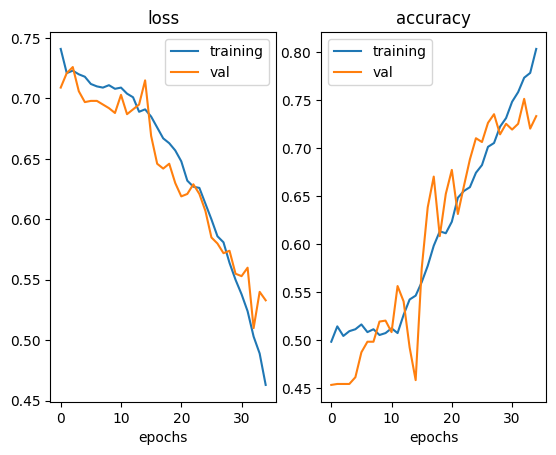

In [ ]:
import seaborn as sns

def training_val_loss_acc(history: dict, epochs= 10):
  fig, (ax0, ax1) = plt.subplots(1, 2, sharex='col')
  x = range(epochs)
  sns.lineplot(x= x, y= history['loss'], ax= ax0, label='training')
  sns.lineplot(x= x, y= history['val_loss'], ax= ax0, label='val')
  ax0.set_title('loss')
  ax0.set_xlabel('epochs')
  sns.lineplot(x= x, y= history['accuracy'], ax= ax1, label='training')
  sns.lineplot(x= x, y= history['val_accuracy'], ax= ax1, label='val')
  ax1.set_title('accuracy')
  ax1.set_xlabel('epochs')
  plt.show()

history = {'loss': loss_per_batch, 'val_loss': val_loss_per_batch, 'accuracy': acc_per_batch, 'val_accuracy': val_acc_per_batch};
training_val_loss_acc(history, 35);

### Modelo con el set de prueba

In [ ]:
# Test evaluation
model.eval()
l = 0
y_label_tensor = torch.empty((0), dtype=torch.float32)
y_pred_tensor = torch.empty((0), dtype=torch.float32)

with torch.no_grad():
    for x, label in tqdm(test_loader):
        x, label = x.to(device), label.to(device)
        logits = model(x).squeeze()
        loss = loss_fn(logits, label.float())
        l += loss.cpu().item()
        pred_probs = torch.round(sm(logits))
        y_label_tensor = torch.cat((y_label_tensor.cpu(), label.cpu().float()), 0)
        y_pred_tensor = torch.cat((y_pred_tensor.cpu(), pred_probs.cpu()), 0)
l = round(l / len(test_loader), 3)
print(f'test: loss {l}')

100%|██████████| 6/6 [00:10<00:00,  1.80s/it]

test: loss 0.505


              precision    recall  f1-score   support

        cats       0.72      0.84      0.78       247
        dogs       0.80      0.67      0.73       242

    accuracy                           0.75       489
   macro avg       0.76      0.75      0.75       489
weighted avg       0.76      0.75      0.75       489

0.7537390838826246


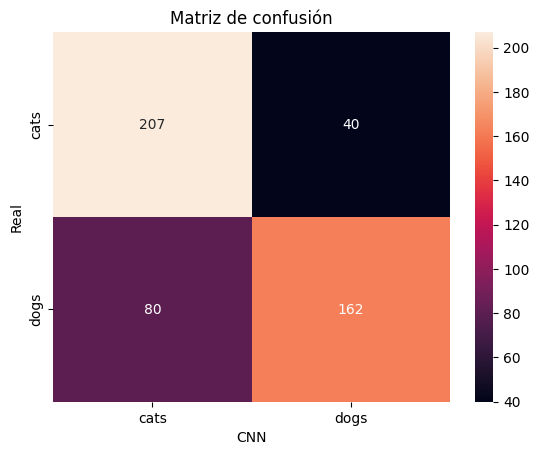

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd

y_true = y_label_tensor.numpy()
y_pred = y_pred_tensor.numpy()

matrix = confusion_matrix(y_true, y_pred)
labels = list(dataset.class_to_idx.keys())
df = pd.DataFrame(matrix, index = labels, columns = labels)

sns.heatmap(df, annot=True, fmt='.0f')
plt.title('Matriz de confusión')
plt.xlabel('CNN')
plt.ylabel('Real')
print(classification_report(y_true, y_pred, target_names=labels))
print(roc_auc_score(y_true, y_pred))

Considerando la clase perro como verdadero tenemos que 141 es nuestro valor de verdaderos positivos, mientras que la clase gato como falso hay 221 verdaderos negativos, esto de nuestra muestra total de prueba de 489 imágenes. En donde más se equivoco al clasificar es en la categoría de los perros, con 101 falsos negativos contra 26 falsos positivos de la clase de gatos. Esto se puede ver tambien en el reporte de clasificación donde el recall de la clase de perros es menor a la de gatos (0.58 < 0.89) mostrando que la proporción de perros bien clasificados con respecto a los perros reales es más baja que la proporción de gatos clasificados con respecto a todos los gatos.

La precisión para identificar gatos es menor al de los perros (0.69 < 0.84) lo que significa que el modelo dice que hay más gatos cuando en realidad no (esto porque un gran valor de estos gatos son en realidad perros)

##### Guardar modelo

In [ ]:
torch.save(model.state_dict(), 'assets/cats_vs_dogs.pth')

### Conclusión

El modelo es capaz de identificar perros y gatos con una exactitud mayor al 70% pero se puede visualizar que conforme aumenta el n° de epochs el conjunto de entrenamiento se aleja de la estimación de validación tanto en perdida como exactitud, por lo que si se desea mejorar el sistema se deben de aplicar una o varias técnicas:

- Data augmentation para evitar el overfitting
- Más imagenes de entrenamiento
- Ajustar los pesos de la función de perdida
- Cambiar la función de perdida u optimizador
- Ajustar pesos en la función de perdida
- Cambiar el numero de hiperparametros (ó de capas)
- Ajustar el threshold de probabilidad de salida (en esta caso de la función sigmoidea haciendo uso de la gráfica Score vs Discrimination Threshold)

Este ejemplo es con el último punto, cambiando el threshold de la función sigmoidea a 0.39 en vez del usual 0.5, entonces si no se pasa ese valor se supondra que la imágen es de un gato (esto para intentar reducir el numero de falsos negativos que el sistema cree que son gatos cuando en realidad no). Haciendo uso de esta técnica hubo una mejora considerable en el recall y la precisión de perros por lo que ahora el clasificador es un poco mejor al clasificar perros.

100%|██████████| 6/6 [00:10<00:00,  1.74s/it]

test: loss 0.505
              precision    recall  f1-score   support

        cats       0.72      0.84      0.78       247
        dogs       0.80      0.67      0.73       242

    accuracy                           0.75       489
   macro avg       0.76      0.75      0.75       489
weighted avg       0.76      0.75      0.75       489

0.7537390838826246


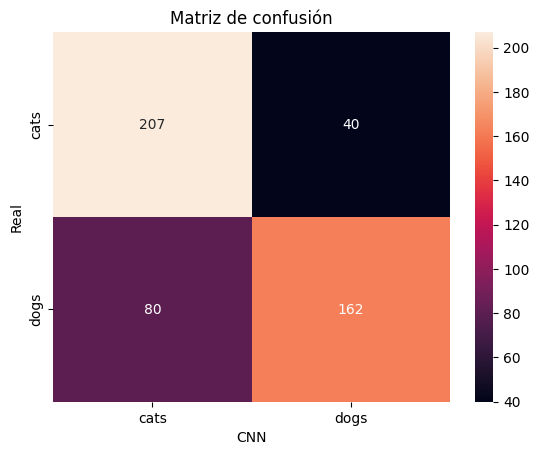

In [ ]:
# Test evaluation
model.eval()
l = 0
y_label_tensor = torch.empty((0), dtype=torch.float32)
y_pred_tensor = torch.empty((0), dtype=torch.float32)

with torch.no_grad():
    for x, label in tqdm(test_loader):
        x, label = x.to(device), label.to(device)
        logits = model(x).squeeze()
        loss = loss_fn(logits, label.float())
        l += loss.cpu().item()
        pred_probs = sm(logits) >= 0.39 #usar un valor de probabilidad menor, se debe de ajustar revisando la gráfica ROC y el discrimination threshold
        y_label_tensor = torch.cat((y_label_tensor.cpu(), label.cpu().float()), 0)
        y_pred_tensor = torch.cat((y_pred_tensor.cpu(), pred_probs.cpu()), 0)
l = round(l / len(test_loader), 3)
print(f'test: loss {l}')

y_true = y_label_tensor.numpy()
y_pred = y_pred_tensor.numpy()

matrix = confusion_matrix(y_true, y_pred)
labels = list(dataset.class_to_idx.keys())
df = pd.DataFrame(matrix, index = labels, columns = labels)

sns.heatmap(df, annot=True, fmt='.0f')
plt.title('Matriz de confusión')
plt.xlabel('CNN')
plt.ylabel('Real')
print(classification_report(y_true, y_pred, target_names=labels))
print(roc_auc_score(y_true, y_pred))